In [1]:
# -*- coding: utf8

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Para evitar a confusão da aula passada, colocando alguns defaults!
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 08 - Amostragem

## Introdução

Durante a segunda parte do curso o uso de amostras vai ser aplicado para resolver problemas complexos. Embora se fala muito de **big data**, na prática, são boas amostras que são utilizadas para responder boas perguntas. Inclusive, existem falácias em **big data** quando a forma da amostra é muito viésada. 

Vamos considerar uma base de dados de voos com atrasos nos estados unidos. Cada linha da tabela é composta de uma data, o número do vôo, destino e atraso do vôo em minutos.

In [4]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/08extra-Amostras/united_summer2015.csv')
df.head()

,Date,Flight Number,Destination,Delay
0,6/1/15,73,HNL,257
1,6/1/15,217,EWR,28
2,6/1/15,237,STL,-3
3,6/1/15,250,SAN,0
4,6/1/15,267,PHL,64


Vamos assumir que esta é nossa **população**. Ou seja, eu estou apenas interessado em estudar dados de voos united do verão de 2015. Além do mais, a tabela representa um censo completo dos atrasos no ano.

A população consiste de quase 14 mil atrasos no ano de 2015. 

In [5]:
df.shape

(13825, 4)

Vamos entender a distribuição dos atrasos:

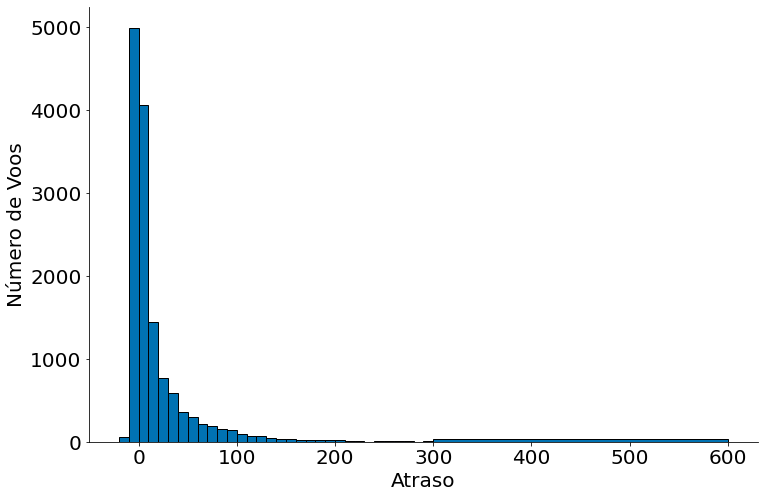

In [6]:
delay_bins = np.append(np.arange(-20, 301, 10), 600)
plt.hist(df['Delay'], bins=delay_bins, edgecolor='k')
plt.xlabel('Atraso')
plt.ylabel('Número de Voos')
despine()

Agora vamos olhar para a mesmo distribuição quanto temos amostras menores dos nossos dados. Em particular, vamos iniciar com o caso de $n=1$. Note como a nova distribuição não parece com os dados da população.

In [7]:
def amostre_n(df, n):
    index = df.index
    novo = np.random.choice(index, size=n)
    return df.loc[novo]

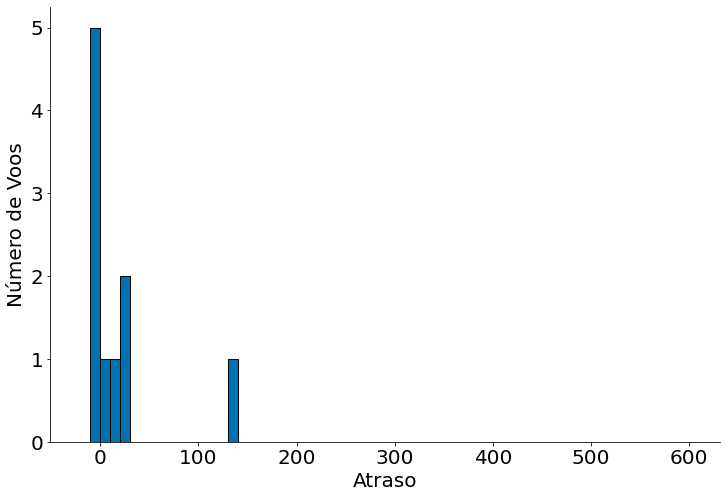

In [8]:
novo = amostre_n(df, 10)
plt.hist(novo['Delay'], bins=delay_bins, edgecolor='k')
plt.xlabel('Atraso')
plt.ylabel('Número de Voos')
despine()

Na animação abaixo conseguimos ver o processo de chegar cada vez mais próximo da distribuição real. Portanto, cada frame da figura mostra o histograma com um valor de $n$ diferente. Quando $n$ se apróxima do valor da população, obviamente, vamos ter uma distribuição similar. Note que isto é uma forma de pensar na lei dos grandes números, ao aumentar $n$, aumentamos a chance de acertar cada bin do meu histograma. Lembre-se da simulação do dado.

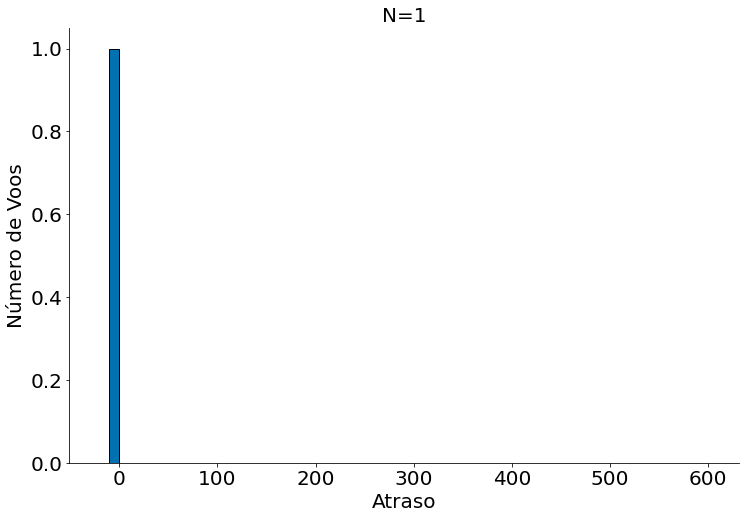

In [9]:
from IPython.display import HTML
import matplotlib.animation

def animate(n):
    novo = amostre_n(df, n)
    plt.clf()
    plt.title('N={}'.format(n))
    plt.hist(novo['Delay'], bins=delay_bins, edgecolor='k')
    plt.xlabel('Atraso')
    plt.ylabel('Número de Voos')
    despine()

fig = plt.figure()
n = np.arange(1, len(df), 200)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=n)

html = HTML(ani.to_html5_video())
html

## Problema de Poucas Amostras em uma Estatística

Note que com poucas amostras teremos problemas em computar a mediana. Por exemplo, abaixo eu escolho 100 voos e a mediana muda batante em cada rodada.

In [10]:
df['Delay'].median()

2.0

In [11]:
for _ in range(10):
    novo = amostre_n(df, 1000)
    print(novo['Delay'].median())

2.0
2.0
3.0
2.0
3.0
3.0
2.0
3.0
4.0
3.0


Além do mais, não podemos fazer nada se geramos amostras com algum viés. Por exemplo, se mensuramos atrasos em um único aeroporto!

In [12]:
for _ in range(10):
    novo = amostre_n(df[df['Destination'] == 'ORD'], 100)
    print(novo['Delay'].median())

3.0
4.5
4.0
5.0
4.5
7.0
4.0
0.5
2.0
6.0


Por fim, com uma amostragem estratificada, podemos garantir que temos uma proporção representativa de cada aeroporto. 

In [13]:
novo = amostre_n(df, 100)
duas_colunas = novo[['Destination', 'Delay']]
print(duas_colunas.groupby('Destination').median())

             Delay
Destination       
ANC           -1.5
BOS            6.0
CLE           -5.5
DEN            4.0
DFW           77.0
EWR            9.0
FLL           37.0
HNL            2.0
IAD           36.0
IAH            5.0
IND           71.0
JFK           -1.0
KOA           12.0
LAS           -2.5
LAX           -1.0
LIH           31.0
OGG            0.0
ORD            4.0
PDX            1.5
PHL           -5.0
PHX            6.0
PIT           -1.0
SAN           23.5
SEA            4.5
SLC           -5.0
SNA           11.0
STL            2.0


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
for train, test in StratifiedShuffleSplit(test_size=200).split(df, df['Destination']):
    duas_colunas = df[['Destination', 'Delay']]
    amostra = duas_colunas.iloc[test]
    print(amostra.groupby('Destination').median())
    break

             Delay
Destination       
ANC           -7.0
ATL           29.0
AUS            9.5
BOS           30.5
BWI           94.0
CLE           41.0
DCA           -8.0
DEN            0.0
DFW           27.0
EWR            3.0
FLL           21.0
HNL            9.0
IAD            2.5
IAH            2.0
IND           -9.0
JFK            5.0
KOA            3.0
LAS           -1.5
LAX            4.0
LIH            0.0
MCO            5.0
MSP            5.0
OGG            3.0
ORD            3.0
PDX            0.0
PHL           -4.0
PHX           -4.0
PIT           19.0
RDU           -4.0
RNO          118.0
SAN            2.0
SEA            0.0
SLC           -6.0
SNA           -3.0
STL           52.0


## Qual o motivo de simular?

Para muitos casos, tipo a distribuição de médias, o teorema central do limite vai nos ajudar teoricamente pois sabemos que os dados da **ditribuição de amostragem** converge para uma normal. Note que isto não vai ser o caso para a mediana, porém podemos simular e ter uma ideia da mesma. Vamos iniciar olhando para a mediana.

Então muitos resultados teóricos podem ser feitos quando pensamos em distribuições amostrais da média, porém para a mediana simular é uma boa solução.

Abaixo brincamos um pouco com a distribuição amostral da mediana, note que a no fim não temos nada muito perto da **normal**.

In [15]:
amostral = []
for _ in range(10000):
    novo = amostre_n(df, 100)
    amostral.append(novo['Delay'].median())

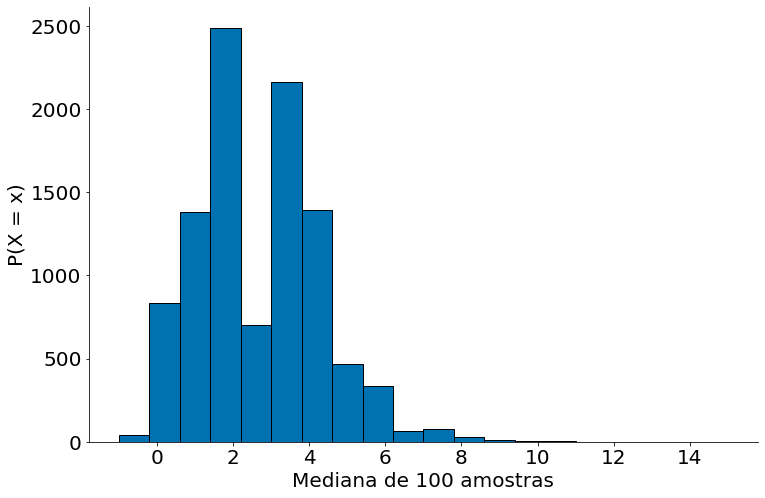

In [16]:
plt.hist(amostral, bins=20, edgecolor='k');
plt.xlabel('Mediana de 100 amostras')
plt.ylabel('P(X = x)')
despine()

## Para Exploração Futura

1. Artigo com a diferença entre ciência e ciência de dados -- https://www.pnas.org/content/pnas/114/33/8689.full.pdf
1. Seção 1.4 do Open Intro
1. Capítulo 10 do Inferential Thinking
1. Leia a documentação do np.random.choice e do StratifiedSampler do sklearn